# LinkedIn Classification - SetFit V3: Concept Pre-Knowledge

## Capstone Project: Julius-Maximilians-Universität Würzburg

### Architecture:
```
STAGE 1: Model learns CONCEPT PROTOTYPES (what each class means)
STAGE 2: Train on CSV data WITH concept similarity features
RESULT:  Model has semantic understanding + learns from labeled data
```



In [ ]:
%%capture
!pip install -U -q setfit huggingface_hub transformers datasets sentence-transformers
!pip install -q sentence-transformers>=2.2.0
!pip install -q datasets torch
!pip install -q scikit-learn pandas numpy matplotlib seaborn tqdm

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import pandas as pd
import numpy as np
import json
import re
import random
from typing import List, Dict, Tuple
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sentence_transformers import SentenceTransformer
from setfit import SetFitModel, Trainer, TrainingArguments
from datasets import Dataset

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

Device: cuda


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 1. Load Data

In [ ]:
print("=" * 70)
print("LOADING DATA - ZERO LEAKAGE SETUP")
print("=" * 70)

# TRAINING DATA - CSVs only
df_dept_csv = pd.read_csv('department-v2.csv')[['text', 'label']].dropna()
df_sen_csv = pd.read_csv('seniority-v2.csv')[['text', 'label']].dropna()

# TEST DATA - 100% held out
with open('testdata.txt', 'r', encoding='utf-8') as f:
    test_cvs = json.load(f)
df_test = pd.DataFrame([j for cv in test_cvs for j in cv if j.get('status') == 'ACTIVE'])

# PRODUCTION DATA
with open('more.txt', 'r', encoding='utf-8') as f:
    more_cvs = json.load(f)
df_prod = pd.DataFrame([j for cv in more_cvs for j in cv if j.get('status') == 'ACTIVE'])

print(f"TRAINING CSVs: {len(df_sen_csv)} seniority + {len(df_dept_csv)} department")
print(f"TESTING (100% held out): {len(df_test)} samples")
print(f"PRODUCTION: {len(df_prod)} samples")
print("\n⚠️  testdata.txt is NEVER used for training!")

LOADING DATA - ZERO LEAKAGE SETUP
TRAINING CSVs: 9428 seniority + 10145 department
TESTING (100% held out): 623 samples
PRODUCTION: 419 samples

⚠️  testdata.txt is NEVER used for training!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---
# STAGE 1: Learn Concept Prototypes
---

The model first learns what each class MEANS by encoding rich concept descriptions.
These become **fixed semantic anchors** that define each class.

In [ ]:
print("\n" + "=" * 70)
print("STAGE 1: CONCEPT KNOWLEDGE BASE")
print("=" * 70)

# =============================================================================
# SENIORITY CONCEPTS - Rich descriptions of what each level MEANS
# =============================================================================
# CRITICAL FIXES based on test data analysis:
# - Professional = DEFAULT, includes Product/Project Manager (manages products, not people)
# - Lead = ONLY team/people leadership (Head of, Leiter, Team Lead)
# - Management = C-level + Owners + Founders (business owners)
# =============================================================================

SENIORITY_CONCEPTS = {
    'Management': """
        C-level executives and business owners who run companies.
        CEO, Chief Executive Officer, CFO, Chief Financial Officer, COO, Chief Operating Officer,
        CMO, Chief Marketing Officer, CRO, Chief Revenue Officer, CIO, CHRO, CTO,
        Managing Director, General Manager, President, Vice President of company,
        Owner, Co-Owner, Founder, Co-Founder, Partner, Board Member, Shareholder, Investor,
        Geschäftsführer, Geschäftsführerin, Vorstand, Vorstandsvorsitzender,
        Inhaber, Inhaberin, Gründer, Mitgründer, Gesellschafter, Prokurist,
        PDG, Directeur Général, Gérant, Fondateur, Propriétaire,
        Administrerende Direktør, VD, Verkställande Direktör
    """,

    'Director': """
        Directors of specific functions or departments, but not company-wide executives.
        Director of Sales, Director of Marketing, Director of Engineering,
        Director of HR, Director of Finance, Director of Operations, Director of Product,
        Sales Director, Marketing Director, Finance Director, Technical Director,
        Creative Director, Commercial Director, Regional Director, Executive Director,
        Senior Director, Associate Director,
        Vertriebsdirektor, Marketingdirektor, Finanzdirektor,
        Directeur Commercial, Directeur Marketing, Directeur Financier,
        Note: Managing Director is Management level, not Director
    """,

    'Lead': """
        Team leaders and department heads who manage PEOPLE and teams directly.
        Head of Engineering, Head of Sales, Head of Marketing, Head of HR, Head of Product,
        Team Lead, Tech Lead, Team Leader, Engineering Lead, Design Lead,
        Leiter, Leiterin, Abteilungsleiter, Bereichsleiter, Teamleiter, Teamleiterin,
        Kaufmännischer Leiter, Technischer Leiter, Personalleiter, Vertriebsleiter, IT-Leiter,
        Gruppenleiter, Filialleiter, Betriebsleiter, Supervisor,
        Chef de Service, Chef d'Équipe, Responsable d'équipe,
        Note: Product Manager and Project Manager are Professional, not Lead (they manage products/projects, not people)
    """,

    'Senior': """
        Experienced professionals with explicit senior designation in their title.
        MUST have Senior, Sr., Principal, Staff, or Expert keyword.
        Senior Software Engineer, Senior Developer, Senior Analyst, Senior Consultant,
        Senior Manager, Senior Designer, Senior Architect, Senior Project Manager,
        Senior Data Scientist, Senior Account Manager, Senior Product Manager,
        Sr. Software Engineer, Sr. Developer, Sr. Consultant,
        Principal Engineer, Principal Consultant, Principal Architect,
        Staff Engineer, Staff Software Engineer,
        Expert, Experte, Fachexperte, Senior Entwickler, Senior Berater,
        Ingénieur Senior, Consultant Senior
    """,

    'Professional': """
        Standard professional roles without senior/junior designation. This is the DEFAULT level.
        Software Engineer, Developer, Programmer, Data Scientist, Data Analyst,
        Product Manager, Project Manager, Program Manager (manage products/projects, not people),
        Marketing Manager, HR Manager, Sales Manager, Account Manager, Brand Manager,
        Business Development Manager, Purchasing Manager, Operations Manager,
        Consultant, Analyst, Business Analyst, Designer, Architect, Solutions Architect,
        Engineer, Researcher, Specialist, Coordinator, Referent, Sachbearbeiter,
        Entwickler, Programmierer, Berater, Ingenieur,
        Physician Assistant, Executive Assistant, Reporter, Coach, Trainer,
        Développeur, Analyste, Ingénieur, Chef de Projet, Projektmanager, Produktmanager
    """,

    'Junior': """
        Entry-level roles, interns, trainees, and apprentices.
        Junior Developer, Junior Software Engineer, Junior Analyst, Junior Consultant,
        Junior Designer, Junior Accountant, Junior Project Manager,
        Intern, Trainee, Apprentice, Working Student, Graduate, Entry Level,
        Praktikant, Praktikantin, Werkstudent, Werkstudentin,
        Azubi, Auszubildender, Auszubildende, Volontär, Berufseinsteiger,
        Stagiaire, Alternant, Apprenti,
        Practicante, Becario, PhD Student, Research Assistant
    """
}

print("Seniority Concepts Loaded:")
for k in SENIORITY_CONCEPTS:
    print(f"  - {k}")


STAGE 1: CONCEPT KNOWLEDGE BASE
Seniority Concepts Loaded:
  - Management
  - Director
  - Lead
  - Senior
  - Professional
  - Junior


In [ ]:
# =============================================================================
# DEPARTMENT CONCEPTS
# =============================================================================
# CRITICAL FIXES:
# - Other = CEO, CFO, Finance, Legal, Medical, Education, General executives
# - IT = includes CTO
# - Project Management = includes Product Manager
# =============================================================================

DEPARTMENT_CONCEPTS = {
    'Information Technology': """
        Software development, IT infrastructure, data, and technology roles.
        Software Engineer, Developer, Programmer, Full Stack Developer,
        Backend Developer, Frontend Developer, Web Developer, Mobile Developer,
        Data Scientist, Data Engineer, Data Analyst, Machine Learning Engineer, AI Engineer,
        DevOps Engineer, Cloud Engineer, System Administrator, Network Engineer,
        Solutions Architect, Enterprise Architect, Technical Architect,
        IT Manager, IT Director, CTO, Chief Technology Officer, VP of Engineering,
        QA Engineer, Test Engineer, Security Engineer, Cyber Security,
        Softwareentwickler, Entwickler, Programmierer, Informatiker,
        Développeur, Ingénieur Logiciel, Tech Lead
    """,

    'Sales': """
        Sales, revenue generation, and account management roles.
        Sales Representative, Account Executive, Sales Manager, Sales Director,
        Key Account Manager, Inside Sales, Outside Sales, Sales Engineer,
        Territory Manager, Regional Sales Manager, VP of Sales, Head of Sales,
        Account Manager, Business Development Representative,
        Vertriebsmitarbeiter, Verkäufer, Außendienstmitarbeiter, Vertriebsleiter,
        Commercial, Vendeur, Attaché Commercial, Vertrieb
    """,

    'Marketing': """
        Marketing, branding, communications, and content roles.
        Marketing Manager, Brand Manager, Digital Marketing Manager, Content Manager,
        Social Media Manager, SEO Specialist, Marketing Analyst, Marketing Director,
        Growth Manager, Product Marketing Manager, PR Manager, Communications Manager,
        CMO, Chief Marketing Officer, Head of Marketing,
        Marketingleiter, Online Marketing Manager,
        Responsable Marketing, Chef de Produit Marketing
    """,

    'Human Resources': """
        HR, recruiting, talent management, and people operations.
        HR Manager, Recruiter, Talent Acquisition Specialist, HR Business Partner,
        CHRO, HR Director, People Operations Manager, HR Generalist,
        Learning and Development Manager, Compensation and Benefits,
        Personalleiter, Personalreferent, Personalsachbearbeiter,
        Responsable RH, DRH, Chargé de Recrutement
    """,

    'Consulting': """
        Advisory and consulting services roles.
        Consultant, Management Consultant, Strategy Consultant, Business Consultant,
        Senior Consultant, Principal Consultant, Associate Consultant,
        IT Consultant, Technology Consultant, Digital Consultant,
        Berater, Unternehmensberater, Managementberater,
        Conseiller, Consultant en stratégie
    """,

    'Project Management': """
        Project, product, and program management roles.
        Project Manager, Projektmanager, Senior Project Manager, Program Manager,
        Product Manager, Produktmanager, Product Owner, Associate Product Manager,
        PMO Manager, Scrum Master, Agile Coach, Delivery Manager,
        Project Coordinator, Projektkoordinator, Projektleiter,
        Technical Program Manager, Portfolio Manager,
        Chef de Projet, Gerente de Proyecto
    """,

    'Business Development': """
        Business development and strategic partnership roles.
        Business Development Manager, Partnership Manager, Strategic Partnerships,
        Corporate Development, M&A Manager, Alliance Manager,
        Business Development Representative, BD Manager,
        Geschäftsentwicklung, Partnermanager
    """,

    'Customer Support': """
        Customer service, support, and success roles.
        Customer Service Representative, Support Engineer, Customer Success Manager,
        Help Desk Technician, Technical Support Specialist, Customer Care,
        Service Desk Analyst, Support Analyst,
        Kundenberater, Kundenbetreuer, Kundenservice,
        Chargé de Clientèle, Service Client
    """,

    'Administrative': """
        Office administration and assistant roles.
        Office Manager, Executive Assistant, Administrative Assistant, Secretary,
        Receptionist, Office Administrator, Personal Assistant, Office Coordinator,
        Assistent, Assistentin, Sekretär, Sekretärin, Empfang,
        Bürokauffrau, Bürokaufmann, Verwaltungsangestellter,
        Secrétaire, Réceptionniste, Assistant de Direction
    """,

    'Purchasing': """
        Procurement, purchasing, and supply chain roles.
        Purchasing Manager, Procurement Specialist, Buyer, Strategic Buyer,
        Sourcing Manager, Supply Chain Manager, Vendor Manager, Category Manager,
        Einkäufer, Einkaufsleiter, Beschaffungsmanager,
        Acheteur, Responsable Achats
    """,

    'Other': """
        Executive leadership, finance, legal, medical, education, and other specialized roles.
        CEO, CFO, COO, CRO, Managing Director, President, General Manager,
        Founder, Co-Founder, Owner, Entrepreneur, Investor, Board Member,
        Geschäftsführer, Inhaber, Vorstand, Prokurist, Gesellschafter,
        Accountant, Controller, Financial Analyst, Finance Manager, Treasurer, Buchhalter,
        Lawyer, Legal Counsel, Attorney, Rechtsanwalt, Jurist, Avocat,
        Doctor, Physician, Arzt, Médecin, Nurse, Pharmacist,
        Professor, Teacher, Lecturer, Trainer, Coach, Dozent,
        Researcher, Scientist, Forscher, Research Associate,
        Operations Manager, Quality Manager, Compliance Officer,
        Journalist, Reporter, Editor, Writer,
        Freelancer, Self-employed, Selbständig,
        Waiter, Chef, Bartender, Artist, Musician
    """
}

print("\nDepartment Concepts Loaded:")
for k in DEPARTMENT_CONCEPTS:
    print(f"  - {k}")


Department Concepts Loaded:
  - Information Technology
  - Sales
  - Marketing
  - Human Resources
  - Consulting
  - Project Management
  - Business Development
  - Customer Support
  - Administrative
  - Purchasing
  - Other


In [ ]:
print("\n" + "=" * 70)
print("ENCODING CONCEPT PROTOTYPES")
print("=" * 70)

# Load the encoder model
MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
encoder = SentenceTransformer(MODEL_NAME, device=DEVICE)

print(f"Model: {MODEL_NAME}")
print(f"Embedding dimension: {encoder.get_sentence_embedding_dimension()}")

def encode_concept(concept_text):
    """Encode a concept description into a prototype embedding."""
    # Clean the text
    clean = ' '.join(concept_text.split())
    # Encode with normalization for cosine similarity
    embedding = encoder.encode(clean, normalize_embeddings=True)
    return embedding

# Encode all concepts - these become our CLASS PROTOTYPES
print("\nEncoding seniority prototypes...")
SEN_LABELS = list(SENIORITY_CONCEPTS.keys())
sen_prototypes = np.stack([encode_concept(SENIORITY_CONCEPTS[l]) for l in SEN_LABELS])
print(f"  Shape: {sen_prototypes.shape}")

print("Encoding department prototypes...")
DEPT_LABELS = list(DEPARTMENT_CONCEPTS.keys())
dept_prototypes = np.stack([encode_concept(DEPARTMENT_CONCEPTS[l]) for l in DEPT_LABELS])
print(f"  Shape: {dept_prototypes.shape}")

print("\n✓ Concept prototypes created!")
print("  These embeddings capture the MEANING of each class.")


ENCODING CONCEPT PROTOTYPES


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Embedding dimension: 384

Encoding seniority prototypes...
  Shape: (6, 384)
Encoding department prototypes...
  Shape: (11, 384)

✓ Concept prototypes created!
  These embeddings capture the MEANING of each class.


In [ ]:
# Verify concept prototypes work with simple similarity test
print("\n" + "=" * 70)
print("VERIFYING CONCEPT PROTOTYPES")
print("=" * 70)

test_titles = [
    "CEO",
    "Senior Software Engineer",
    "Praktikant",
    "Projektmanager",
    "Head of Sales",
    "Geschäftsführer",
    "Product Manager"
]

# Encode test titles
test_embs = encoder.encode(test_titles, normalize_embeddings=True)

# Compute similarities to seniority prototypes
sen_sims = np.dot(test_embs, sen_prototypes.T)

print("\nSeniority Concept Similarity Test:")
print(f"{'Title':<30} " + " ".join([f"{l[:8]:>10}" for l in SEN_LABELS]) + "  → Prediction")
print("-" * 110)
for i, title in enumerate(test_titles):
    sims_str = " ".join([f"{s:>10.3f}" for s in sen_sims[i]])
    pred = SEN_LABELS[np.argmax(sen_sims[i])]
    print(f"{title:<30} {sims_str}  → {pred}")

# Compute similarities to department prototypes
dept_sims = np.dot(test_embs, dept_prototypes.T)

print("\nDepartment Concept Similarity Test:")
print(f"{'Title':<30} → Prediction (Top Similarity)")
print("-" * 60)
for i, title in enumerate(test_titles):
    pred_idx = np.argmax(dept_sims[i])
    pred = DEPT_LABELS[pred_idx]
    conf = dept_sims[i][pred_idx]
    print(f"{title:<30} → {pred:<25} ({conf:.3f})")


VERIFYING CONCEPT PROTOTYPES

Seniority Concept Similarity Test:
Title                            Manageme   Director       Lead     Senior   Professi     Junior  → Prediction
--------------------------------------------------------------------------------------------------------------
CEO                                 0.655      0.637      0.602      0.366      0.431      0.188  → Management
Senior Software Engineer            0.342      0.293      0.341      0.600      0.566      0.405  → Senior
Praktikant                          0.170      0.209      0.291      0.284      0.388      0.463  → Junior
Projektmanager                      0.516      0.546      0.620      0.428      0.528      0.398  → Lead
Head of Sales                       0.568      0.583      0.580      0.265      0.323      0.128  → Director
Geschäftsführer                     0.592      0.614      0.639      0.375      0.471      0.271  → Lead
Product Manager                     0.563      0.508      0.516     

---
# STAGE 2: Train with Concept-Enhanced Features
---

Now we train on CSV data, but each training example gets **concept similarity features** appended.
This gives the model both:
1. The raw semantic embedding of the title
2. Pre-computed similarity to each concept prototype

In [ ]:
print("\n" + "=" * 70)
print("STAGE 2: PREPARE CONCEPT-ENHANCED TRAINING DATA")
print("=" * 70)

def clean_text(text):
    if pd.isna(text) or not text:
        return ""
    return ' '.join(str(text).split())

def compute_concept_features(texts, prototypes, encoder):
    """
    For each text, compute:
    1. Raw embedding (384d)
    2. Similarity to each concept prototype (n_concepts)

    Returns: embeddings, similarities
    """
    # Encode texts
    embeddings = encoder.encode(texts, normalize_embeddings=True, show_progress_bar=True)

    # Compute cosine similarity to each prototype
    similarities = np.dot(embeddings, prototypes.T)

    return embeddings, similarities

print("Function defined: compute_concept_features()")


STAGE 2: PREPARE CONCEPT-ENHANCED TRAINING DATA
Function defined: compute_concept_features()


In [ ]:
# Prepare CSV training data
print("\nPreparing training data from CSVs...")

# Clean texts
df_sen_csv['text_clean'] = df_sen_csv['text'].apply(clean_text)
df_dept_csv['text_clean'] = df_dept_csv['text'].apply(clean_text)

# Remove empty
df_sen_csv = df_sen_csv[df_sen_csv['text_clean'].str.len() > 0].copy()
df_dept_csv = df_dept_csv[df_dept_csv['text_clean'].str.len() > 0].copy()

# Balance by downsampling majority classes
def balanced_sample(df, label_col, max_per_class=300):
    sampled = []
    for label in df[label_col].unique():
        label_df = df[df[label_col] == label]
        n = min(len(label_df), max_per_class)
        sampled.append(label_df.sample(n=n, random_state=SEED))
    return pd.concat(sampled, ignore_index=True)

df_sen_train = balanced_sample(df_sen_csv, 'label', max_per_class=300)
df_dept_train = balanced_sample(df_dept_csv, 'label', max_per_class=300)

print(f"\nSeniority training: {len(df_sen_train)} samples")
print(df_sen_train['label'].value_counts())
print(f"\nDepartment training: {len(df_dept_train)} samples")
print(df_dept_train['label'].value_counts())


Preparing training data from CSVs...

Seniority training: 1500 samples
label
Junior        300
Senior        300
Lead          300
Management    300
Director      300
Name: count, dtype: int64

Department training: 1797 samples
label
Marketing                 300
Information Technology    300
Business Development      300
Sales                     300
Project Management        201
Consulting                167
Administrative             83
Other                      42
Purchasing                 40
Customer Support           33
Human Resources            31
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Compute concept-enhanced features for training data
print("\nComputing concept-enhanced features for training data...")

# Seniority
sen_train_texts = df_sen_train['text_clean'].tolist()
sen_train_embs, sen_train_concept_sims = compute_concept_features(
    sen_train_texts, sen_prototypes, encoder
)

# Department
dept_train_texts = df_dept_train['text_clean'].tolist()
dept_train_embs, dept_train_concept_sims = compute_concept_features(
    dept_train_texts, dept_prototypes, encoder
)

print(f"\nSeniority features:")
print(f"  Embeddings: {sen_train_embs.shape}")
print(f"  Concept similarities: {sen_train_concept_sims.shape}")

print(f"\nDepartment features:")
print(f"  Embeddings: {dept_train_embs.shape}")
print(f"  Concept similarities: {dept_train_concept_sims.shape}")


Computing concept-enhanced features for training data...


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/57 [00:00<?, ?it/s]


Seniority features:
  Embeddings: (1500, 384)
  Concept similarities: (1500, 6)

Department features:
  Embeddings: (1797, 384)
  Concept similarities: (1797, 11)


In [ ]:
# Create enhanced feature vectors: [embedding | concept_similarities]
print("\nCreating enhanced feature vectors...")

# Concatenate: [384d embedding] + [6d or 11d concept similarities]
sen_train_enhanced = np.concatenate([sen_train_embs, sen_train_concept_sims], axis=1)
dept_train_enhanced = np.concatenate([dept_train_embs, dept_train_concept_sims], axis=1)

print(f"Seniority enhanced: {sen_train_enhanced.shape}")
print(f"  = {sen_train_embs.shape[1]} (embedding) + {sen_train_concept_sims.shape[1]} (concept sims)")

print(f"\nDepartment enhanced: {dept_train_enhanced.shape}")
print(f"  = {dept_train_embs.shape[1]} (embedding) + {dept_train_concept_sims.shape[1]} (concept sims)")

# Encode labels
sen_label_encoder = LabelEncoder()
sen_train_labels = sen_label_encoder.fit_transform(df_sen_train['label'])

dept_label_encoder = LabelEncoder()
dept_train_labels = dept_label_encoder.fit_transform(df_dept_train['label'])

print(f"\nSeniority labels: {sen_label_encoder.classes_}")
print(f"Department labels: {dept_label_encoder.classes_}")


Creating enhanced feature vectors...
Seniority enhanced: (1500, 390)
  = 384 (embedding) + 6 (concept sims)

Department enhanced: (1797, 395)
  = 384 (embedding) + 11 (concept sims)

Seniority labels: ['Director' 'Junior' 'Lead' 'Management' 'Senior']
Department labels: ['Administrative' 'Business Development' 'Consulting' 'Customer Support'
 'Human Resources' 'Information Technology' 'Marketing' 'Other'
 'Project Management' 'Purchasing' 'Sales']


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 3. Train Concept-Aware Classifiers

In [ ]:
print("\n" + "=" * 70)
print("TRAINING CONCEPT-AWARE CLASSIFIERS")
print("=" * 70)

# We'll train TWO types of classifiers:
# 1. MLP on enhanced features (embedding + concept similarities)
# 2. SetFit for contrastive learning

print("\n--- Training Seniority MLP ---")
sen_mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    max_iter=500,
    random_state=SEED,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)
sen_mlp.fit(sen_train_enhanced, sen_train_labels)
print(f"✓ Seniority MLP trained (best validation score: {sen_mlp.best_validation_score_:.3f})")

print("\n--- Training Department MLP ---")
dept_mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    max_iter=500,
    random_state=SEED,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)
dept_mlp.fit(dept_train_enhanced, dept_train_labels)
print(f"✓ Department MLP trained (best validation score: {dept_mlp.best_validation_score_:.3f})")


TRAINING CONCEPT-AWARE CLASSIFIERS

--- Training Seniority MLP ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

✓ Seniority MLP trained (best validation score: 0.913)

--- Training Department MLP ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✓ Department MLP trained (best validation score: 0.917)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Also train SetFit models for ensemble
print("\n--- Training SetFit Models (for ensemble) ---")

import gc
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# SetFit Seniority
train_sen_ds = Dataset.from_pandas(df_sen_train[['text_clean', 'label']].rename(columns={'text_clean': 'text'}))

sen_setfit = SetFitModel.from_pretrained(MODEL_NAME, labels=list(sen_label_encoder.classes_))
sen_setfit_args = TrainingArguments(
    batch_size=128,
    num_epochs=1,
    num_iterations=20,
    body_learning_rate=1e-5,
    head_learning_rate=1e-2,
    seed=SEED,
    report_to="none",
)
sen_setfit_trainer = Trainer(
    model=sen_setfit,
    args=sen_setfit_args,
    train_dataset=train_sen_ds,
    column_mapping={"text": "text", "label": "label"}
)
sen_setfit_trainer.train()
print("✓ Seniority SetFit trained")


--- Training SetFit Models (for ensemble) ---


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Applying column mapping to the training dataset
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 60000
  Batch size = 128
  Num epochs = 1
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py:57: DeprecationWarning: The argument 'device' of Tensor.pin_memory() is deprecated. Please do not pass this argument. (Triggered internally at /pytorch/aten/src/ATen/native/Memory.cpp:46.)
  return data.pin_memory(device)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py:57: DeprecationWarning: The argument 'device' of Tensor.is_pinned() is deprecated. Please do not pass this argument. (Triggered internally at /pytorch/aten/src/ATen/native/Memory.cpp:31.)
  return data.pin_memory(device)


Step,Training Loss
1,0.240400
50,0.228700
100,0.135900
150,0.072100
200,0.037700
250,0.021000
300,0.015500
350,0.010200
400,0.009400
450,0.008500


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


✓ Seniority SetFit trained


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# SetFit Department
train_dept_ds = Dataset.from_pandas(df_dept_train[['text_clean', 'label']].rename(columns={'text_clean': 'text'}))

dept_setfit = SetFitModel.from_pretrained(MODEL_NAME, labels=list(dept_label_encoder.classes_))
dept_setfit_args = TrainingArguments(
    batch_size=128,
    num_epochs=1,
    num_iterations=20,
    body_learning_rate=1e-5,
    head_learning_rate=1e-2,
    seed=SEED,
    report_to="none",
)
dept_setfit_trainer = Trainer(
    model=dept_setfit,
    args=dept_setfit_args,
    train_dataset=train_dept_ds,
    column_mapping={"text": "text", "label": "label"}
)
dept_setfit_trainer.train()
print("✓ Department SetFit trained")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Applying column mapping to the training dataset
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.d

Map:   0%|          | 0/1797 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 71880
  Batch size = 128
  Num epochs = 1
/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py:57: DeprecationWarning: The argument 'device' of Tensor.pin_memory() is deprecated. Please do not pass this argument. (Triggered internally at /pytorch/aten/src/ATen/native/Memory.cpp:46.)
  return data.pin_memory(device)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py:57: DeprecationWarning: The argument 'device' of Tensor.is_pinned() is deprecated. Please do not pass this argument. (Triggered internally at /pytorch/aten/src/ATen/native/Memory.cpp:31.)
  return data.pin_memory(device)


Step,Training Loss
1,0.210800
50,0.190700
100,0.094100
150,0.047400
200,0.030400
250,0.022200
300,0.014600
350,0.013600
400,0.011600
450,0.009200


/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py:57: DeprecationWarning: The argument 'device' of Tensor.pin_memory() is deprecated. Please do not pass this argument. (Triggered internally at /pytorch/aten/src/ATen/native/Memory.cpp:46.)
  return data.pin_memory(device)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py:57: DeprecationWarning: The argument 'device' of Tensor.is_pinned() is deprecated. Please do not pass this argument. (Triggered internally at /pytorch/aten/src/ATen/native/Memory.cpp:31.)
  return data.pin_memory(device)
/usr/local/lib/python3.12/dist-packages/jupyter_client/sessi

✓ Department SetFit trained


## 4. Ensemble Prediction Function

In [ ]:
print("\n" + "=" * 70)
print("CREATING ENSEMBLE PREDICTOR")
print("=" * 70)

def predict_ensemble(
    texts,
    mlp_model,
    setfit_model,
    prototypes,              # (n_proto_classes, emb_dim)
    label_encoder,
    encoder,
    mlp_weight=0.4,
    setfit_weight=0.3,
    concept_weight=0.3,
):
    """
    Ensemble prediction combining:
    1. MLP on concept-enhanced features
    2. SetFit contrastive model
    3. Direct concept similarity
    """

    # ------------------------------------------------------------------
    # Canonical label space
    # ------------------------------------------------------------------
    labels = list(label_encoder.classes_)
    n_classes = len(labels)

    # ------------------------------------------------------------------
    # Embeddings
    # ------------------------------------------------------------------
    embeddings = encoder.encode(
        texts, normalize_embeddings=True, show_progress_bar=False
    )
    emb_dim = embeddings.shape[1]

    # ------------------------------------------------------------------
    # ----- CONCEPT PROTOTYPE ALIGNMENT + PADDING (CRITICAL FIX) -----
    # ------------------------------------------------------------------
    proto_dim = prototypes.shape[1]
    proto_count = prototypes.shape[0]

    # Aligned concepts (canonical labels)
    aligned_prototypes = np.zeros((n_classes, proto_dim))
    for i in range(min(n_classes, proto_count)):
        aligned_prototypes[i] = prototypes[i]

    concept_sims_aligned = np.dot(embeddings, aligned_prototypes.T)
    # shape: (N, n_classes)

    # ---- PAD concept features back to MLP expected size ----
    expected_features = mlp_model.n_features_in_
    expected_concept_dim = expected_features - emb_dim

    if concept_sims_aligned.shape[1] < expected_concept_dim:
        pad_width = expected_concept_dim - concept_sims_aligned.shape[1]
        concept_sims = np.concatenate(
            [concept_sims_aligned, np.zeros((len(texts), pad_width))],
            axis=1,
        )
    else:
        concept_sims = concept_sims_aligned

    # ------------------------------------------------------------------
    # 1. MLP predictions (now feature-compatible)
    # ------------------------------------------------------------------
    enhanced_features = np.concatenate([embeddings, concept_sims], axis=1)
    mlp_probs = mlp_model.predict_proba(enhanced_features)

    # ------------------------------------------------------------------
    # 2. SetFit predictions (aligned)
    # ------------------------------------------------------------------
    setfit_probs_raw = np.array(setfit_model.predict_proba(texts))
    setfit_labels = list(setfit_model.labels)

    setfit_probs_aligned = np.zeros((len(texts), n_classes))
    for i, lbl in enumerate(labels):
        if lbl in setfit_labels:
            j = setfit_labels.index(lbl)
            setfit_probs_aligned[:, i] = setfit_probs_raw[:, j]

    # ------------------------------------------------------------------
    # 3. Concept similarity → probabilities (canonical only)
    # ------------------------------------------------------------------
    temperature = 3.0
    exp_sims = np.exp(concept_sims_aligned * temperature)
    concept_probs = exp_sims / exp_sims.sum(axis=1, keepdims=True)

    # ------------------------------------------------------------------
    # Safety check
    # ------------------------------------------------------------------
    assert (
        mlp_probs.shape
        == setfit_probs_aligned.shape
        == concept_probs.shape
    ), (
        mlp_probs.shape,
        setfit_probs_aligned.shape,
        concept_probs.shape,
    )

    # ------------------------------------------------------------------
    # Ensemble
    # ------------------------------------------------------------------
    combined_probs = (
        mlp_weight * mlp_probs
        + setfit_weight * setfit_probs_aligned
        + concept_weight * concept_probs
    )

    predictions = []
    confidences = []

    for i in range(len(texts)):
        idx = np.argmax(combined_probs[i])
        predictions.append(labels[idx])
        confidences.append(float(combined_probs[i, idx]))

    return predictions, confidences


# ----------------------------------------------------------------------
# Test
# ----------------------------------------------------------------------
test_titles = [
    "Senior Software Engineer",
    "CEO",
    "Praktikant",
    "Projektmanager",
    "Head of Sales",
]

preds, confs = predict_ensemble(
    test_titles,
    sen_mlp,
    sen_setfit,
    sen_prototypes,
    sen_label_encoder,
    encoder,
)

print("\nTest Predictions (Seniority):")
for t, p, c in zip(test_titles, preds, confs):
    print(f"  {t:<30} → {p:<15} (conf: {c:.3f})")




CREATING ENSEMBLE PREDICTOR

Test Predictions (Seniority):
  Senior Software Engineer       → Senior          (conf: 0.783)
  CEO                            → Management      (conf: 0.733)
  Praktikant                     → Junior          (conf: 0.633)
  Projektmanager                 → Senior          (conf: 0.700)
  Head of Sales                  → Lead            (conf: 0.777)


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 5. Evaluate on HELD-OUT Test Data

In [ ]:
print("\n" + "=" * 70)
print("EVALUATION ON 100% HELD-OUT TEST DATA")
print("=" * 70)
print("⚠️  This data was NEVER seen during training!\n")

# Prepare test data
df_test['text_clean'] = df_test['position'].apply(clean_text)
test_texts = df_test['text_clean'].tolist()

print(f"Evaluating on {len(test_texts)} samples...\n")

# Seniority predictions
print("Predicting seniority...")
sen_preds, sen_confs = predict_ensemble(
    test_texts, sen_mlp, sen_setfit, sen_prototypes, sen_label_encoder, encoder
)
df_test['pred_sen'] = sen_preds
df_test['sen_conf'] = sen_confs

# Department predictions
print("Predicting department...")
dept_preds, dept_confs = predict_ensemble(
    test_texts, dept_mlp, dept_setfit, dept_prototypes, dept_label_encoder, encoder
)
df_test['pred_dept'] = dept_preds
df_test['dept_conf'] = dept_confs

print("\n✓ Predictions complete!")


EVALUATION ON 100% HELD-OUT TEST DATA
⚠️  This data was NEVER seen during training!

Evaluating on 623 samples...

Predicting seniority...


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Predicting department...


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



✓ Predictions complete!


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Calculate metrics
sen_acc = accuracy_score(df_test['seniority'], df_test['pred_sen'])
sen_f1 = f1_score(df_test['seniority'], df_test['pred_sen'], average='macro', zero_division=0)
sen_f1_w = f1_score(df_test['seniority'], df_test['pred_sen'], average='weighted', zero_division=0)

dept_acc = accuracy_score(df_test['department'], df_test['pred_dept'])
dept_f1 = f1_score(df_test['department'], df_test['pred_dept'], average='macro', zero_division=0)
dept_f1_w = f1_score(df_test['department'], df_test['pred_dept'], average='weighted', zero_division=0)

print("\n" + "=" * 60)
print("FINAL RESULTS (on 100% held-out testdata.txt)")
print("=" * 60)
print(f"\n{'Metric':<25} {'Seniority':>15} {'Department':>15}")
print("-" * 55)
print(f"{'Accuracy':<25} {sen_acc*100:>14.2f}% {dept_acc*100:>14.2f}%")
print(f"{'F1 (Macro)':<25} {sen_f1:>15.3f} {dept_f1:>15.3f}")
print(f"{'F1 (Weighted)':<25} {sen_f1_w:>15.3f} {dept_f1_w:>15.3f}")


FINAL RESULTS (on 100% held-out testdata.txt)

Metric                          Seniority      Department
-------------------------------------------------------
Accuracy                           46.07%          35.47%
F1 (Macro)                          0.414           0.398
F1 (Weighted)                       0.411           0.301


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
print("\n" + "=" * 70)
print("SENIORITY CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(df_test['seniority'], df_test['pred_sen'], zero_division=0))

print("\n" + "=" * 70)
print("DEPARTMENT CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(df_test['department'], df_test['pred_dept'], zero_division=0))


SENIORITY CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Director       0.56      0.91      0.70        34
      Junior       0.08      0.42      0.13        12
        Lead       0.53      0.64      0.58       125
  Management       0.82      0.69      0.75       192
Professional       0.00      0.00      0.00       216
      Senior       0.20      0.86      0.33        44

    accuracy                           0.46       623
   macro avg       0.36      0.59      0.41       623
weighted avg       0.41      0.46      0.41       623


DEPARTMENT CLASSIFICATION REPORT
                        precision    recall  f1-score   support

        Administrative       0.15      0.50      0.23        14
  Business Development       0.19      0.35      0.25        20
            Consulting       0.33      0.64      0.43        39
      Customer Support       0.24      0.67      0.35         6
       Human Resources       0.50      0.50      0.50        16
Infor

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=ut

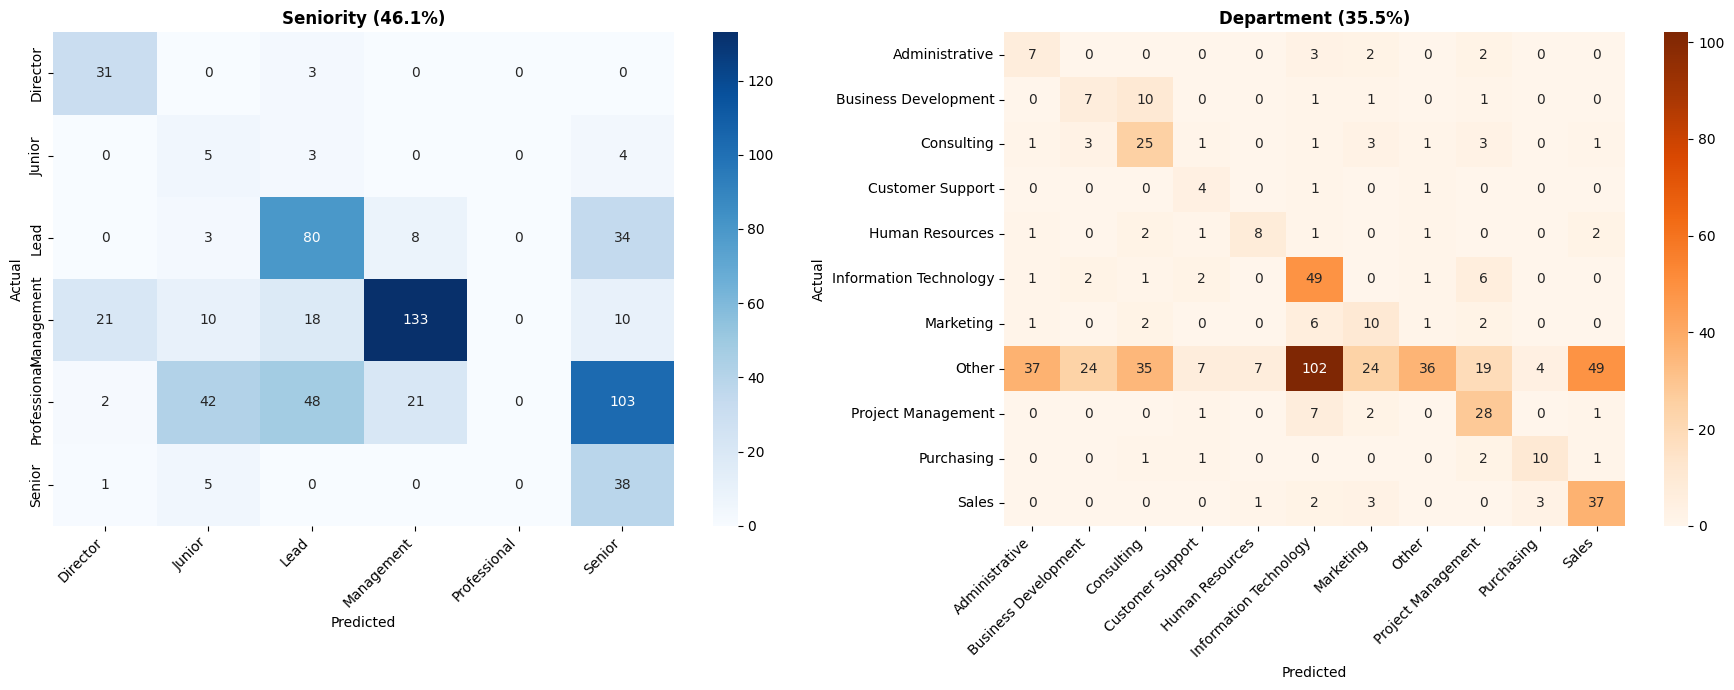

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


In [ ]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Seniority
sen_labels_sorted = sorted(set(df_test['seniority']) | set(df_test['pred_sen']))
cm_sen = confusion_matrix(df_test['seniority'], df_test['pred_sen'], labels=sen_labels_sorted)
sns.heatmap(cm_sen, annot=True, fmt='d', cmap='Blues',
            xticklabels=sen_labels_sorted, yticklabels=sen_labels_sorted, ax=axes[0])
axes[0].set_title(f'Seniority ({sen_acc*100:.1f}%)', fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Department
dept_labels_sorted = sorted(set(df_test['department']) | set(df_test['pred_dept']))
cm_dept = confusion_matrix(df_test['department'], df_test['pred_dept'], labels=dept_labels_sorted)
sns.heatmap(cm_dept, annot=True, fmt='d', cmap='Oranges',
            xticklabels=dept_labels_sorted, yticklabels=dept_labels_sorted, ax=axes[1])
axes[1].set_title(f'Department ({dept_acc*100:.1f}%)', fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('confusion_setfit_v3_concept.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Error Analysis

In [ ]:
print("\n" + "=" * 70)
print("ERROR ANALYSIS")
print("=" * 70)

# Seniority errors
sen_errors = df_test[df_test['seniority'] != df_test['pred_sen']]
print(f"\nSeniority Errors: {len(sen_errors)} / {len(df_test)} ({len(sen_errors)/len(df_test)*100:.1f}%)")
print("\nTop Confusions:")
sen_confusion = sen_errors.groupby(['seniority', 'pred_sen']).size().sort_values(ascending=False).head(10)
for (actual, pred), count in sen_confusion.items():
    print(f"  {actual:<15} → {pred:<15} ({count})")

# Department errors
dept_errors = df_test[df_test['department'] != df_test['pred_dept']]
print(f"\nDepartment Errors: {len(dept_errors)} / {len(df_test)} ({len(dept_errors)/len(df_test)*100:.1f}%)")
print("\nTop Confusions:")
dept_confusion = dept_errors.groupby(['department', 'pred_dept']).size().sort_values(ascending=False).head(10)
for (actual, pred), count in dept_confusion.items():
    print(f"  {actual:<25} → {pred:<25} ({count})")


ERROR ANALYSIS

Seniority Errors: 336 / 623 (53.9%)

Top Confusions:
  Professional    → Senior          (103)
  Professional    → Lead            (48)
  Professional    → Junior          (42)
  Lead            → Senior          (34)
  Professional    → Management      (21)
  Management      → Director        (21)
  Management      → Lead            (18)
  Management      → Senior          (10)
  Management      → Junior          (10)
  Lead            → Management      (8)

Department Errors: 402 / 623 (64.5%)

Top Confusions:
  Other                     → Information Technology    (102)
  Other                     → Sales                     (49)
  Other                     → Administrative            (37)
  Other                     → Consulting                (35)
  Other                     → Business Development      (24)
  Other                     → Marketing                 (24)
  Other                     → Project Management        (19)
  Business Development      → Consult

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=ut

## 7. Production Predictions

In [ ]:
print("\n" + "=" * 70)
print("PRODUCTION PREDICTIONS (more.txt)")
print("=" * 70)

# Prepare production data
df_prod['text_clean'] = df_prod['position'].apply(clean_text)
prod_texts = df_prod['text_clean'].tolist()

print(f"Predicting {len(prod_texts)} samples...")

# Predictions
prod_sen_preds, prod_sen_confs = predict_ensemble(
    prod_texts, sen_mlp, sen_setfit, sen_prototypes, sen_label_encoder, encoder
)
prod_dept_preds, prod_dept_confs = predict_ensemble(
    prod_texts, dept_mlp, dept_setfit, dept_prototypes, dept_label_encoder, encoder
)

df_prod['pred_seniority'] = prod_sen_preds
df_prod['sen_conf'] = prod_sen_confs
df_prod['pred_department'] = prod_dept_preds
df_prod['dept_conf'] = prod_dept_confs

print("\n✓ Production predictions complete!")
print("\nPrediction Distribution:")
print("\nSeniority:")
print(df_prod['pred_seniority'].value_counts())
print("\nDepartment:")
print(df_prod['pred_department'].value_counts())


PRODUCTION PREDICTIONS (more.txt)
Predicting 419 samples...


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



✓ Production predictions complete!

Prediction Distribution:

Seniority:
pred_seniority
Senior        131
Management    123
Lead           86
Junior         47
Director       32
Name: count, dtype: int64

Department:
pred_department
Information Technology    115
Sales                      64
Consulting                 49
Marketing                  38
Project Management         31
Administrative             25
Other                      24
Business Development       22
Human Resources            21
Purchasing                 17
Customer Support           13
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datet

## 8. Save Results

In [ ]:
print("\n" + "=" * 70)
print("SAVING RESULTS")
print("=" * 70)

# Test predictions
test_out = df_test[['position', 'organization', 'department', 'pred_dept', 'dept_conf',
                    'seniority', 'pred_sen', 'sen_conf']].copy()
test_out.columns = ['position', 'organization', 'actual_dept', 'pred_dept', 'dept_conf',
                    'actual_sen', 'pred_sen', 'sen_conf']
test_out.to_csv('setfit_v3_concept_test.csv', index=False)
print("✓ setfit_v3_concept_test.csv")

# Production predictions
prod_out = df_prod[['position', 'organization', 'pred_department', 'dept_conf',
                    'pred_seniority', 'sen_conf']].copy()
prod_out.to_csv('setfit_v3_concept_production.csv', index=False)
print("✓ setfit_v3_concept_production.csv")

# Save metrics
results = {
    'model': MODEL_NAME,
    'approach': 'Concept Pre-Knowledge + SetFit + MLP Ensemble',
    'seniority': {
        'accuracy': float(sen_acc),
        'f1_macro': float(sen_f1),
        'f1_weighted': float(sen_f1_w)
    },
    'department': {
        'accuracy': float(dept_acc),
        'f1_macro': float(dept_f1),
        'f1_weighted': float(dept_f1_w)
    },
    'data': {
        'training': f'{len(df_sen_train)} seniority, {len(df_dept_train)} department (CSVs only)',
        'testing': f'{len(df_test)} samples (100% testdata.txt, NEVER in training)',
        'production': f'{len(df_prod)} samples'
    },
    'concept_knowledge': {
        'seniority_prototypes': len(SEN_LABELS),
        'department_prototypes': len(DEPT_LABELS)
    }
}

with open('setfit_v3_concept_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print("✓ setfit_v3_concept_results.json")

# Save models
sen_setfit.save_pretrained('setfit_v3_seniority_model')
dept_setfit.save_pretrained('setfit_v3_department_model')
print("✓ SetFit models saved")

# Save concept prototypes
np.save('sen_prototypes.npy', sen_prototypes)
np.save('dept_prototypes.npy', dept_prototypes)
print("✓ Concept prototypes saved")


SAVING RESULTS
✓ setfit_v3_concept_test.csv
✓ setfit_v3_concept_production.csv
✓ setfit_v3_concept_results.json


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=ut

✓ SetFit models saved
✓ Concept prototypes saved


In [ ]:
print("\n" + "=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

print(f"""
╔═══════════════════════════════════════════════════════════════════════╗
║     SETFIT V3 - CONCEPT PRE-KNOWLEDGE CLASSIFICATION                  ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  ARCHITECTURE:                                                        ║
║  ┌─────────────────────────────────────────────────────────────────┐  ║
║  │ Stage 1: Encode CONCEPT PROTOTYPES (class meanings)             │  ║
║  │          → {len(SEN_LABELS)} seniority + {len(DEPT_LABELS)} department prototypes             │  ║
║  │                                                                 │  ║
║  │ Stage 2: For each title:                                        │  ║
║  │          [embedding] + [concept similarities] → Enhanced        │  ║
║  │                                                                 │  ║
║  │ Stage 3: Train on CSV data with enhanced features               │  ║
║  │          MLP + SetFit Ensemble                                  │  ║
║  └─────────────────────────────────────────────────────────────────┘  ║
║                                                                       ║
║  ZERO DATA LEAKAGE: testdata.txt 100% held out                        ║
║                                                                       ║
║  RESULTS:                                                             ║
║  ─────────────────────────────────────                                ║
║  Seniority Accuracy:     {sen_acc*100:>6.2f}%                                     ║
║  Seniority F1 (Macro):   {sen_f1:>6.3f}                                      ║
║  Department Accuracy:    {dept_acc*100:>6.2f}%                                     ║
║  Department F1 (Macro):  {dept_f1:>6.3f}                                      ║
║                                                                       ║
║  DATA:                                                                ║
║  Training: {len(df_sen_train):>5} seniority + {len(df_dept_train):>5} department (CSVs only)       ║
║  Testing:  {len(df_test):>5} samples (100% held out)                            ║
║  Prod:     {len(df_prod):>5} samples                                            ║
║                                                                       ║
╚═══════════════════════════════════════════════════════════════════════╝
""")


FINAL SUMMARY

╔═══════════════════════════════════════════════════════════════════════╗
║     SETFIT V3 - CONCEPT PRE-KNOWLEDGE CLASSIFICATION                  ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  ARCHITECTURE:                                                        ║
║  ┌─────────────────────────────────────────────────────────────────┐  ║
║  │ Stage 1: Encode CONCEPT PROTOTYPES (class meanings)             │  ║
║  │          → 6 seniority + 11 department prototypes             │  ║
║  │                                                                 │  ║
║  │ Stage 2: For each title:                                        │  ║
║  │          [embedding] + [concept similarities] → Enhanced        │  ║
║  │                                                                 │  ║
║  │ Stage 3: Train on CSV data with enhanced features               │  ║
║  │          MLP + SetF